In [1]:
# A set of putative basket and martinotti cells
cells = {
         'Basket':{'segID':[864691135269913253,
                            864691135994717610,
                            864691135644647151,
                            #
                            864691136965924814,
                            864691135875962451,
                            864691135307240262,
                            864691136601891793,
                            864691135341149893,
                            864691135212725632,
                            864691135939796646,
                            864691135269913253,
                            864691135396580129,
                            864691135771743563,
                            864691135446872916,
                            #
                            864691135403927534,
                            864691135815629903,
                            864691135737012612,
                            864691135873741966,
                            864691135644647151,
                            864691135807467037,
                            864691135528023492,
                            864691135212725632,
                            864691137197014081,
                            864691135307240262]},
    
         'Martinotti':{'segID':[864691135654096066,
                                864691136483096108,
                                864691136866902638,
                                864691135390890482,
                                864691136296781083,
                                864691135697569813,
                                864691135575230238,
                                864691136056318680,
                                864691136296781083,
                                #
                                864691136871043694,
                                864691136436386718,
                                864691135394616306,
                                864691135584090435]}
        }

In [2]:
from caveclient import CAVEclient
import nglui
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
# this is the datastack name of the public release
# passing it will auto-configure many of the services
client = CAVEclient('minnie65_public_v117')

In [3]:
def get_synaptic_distances(segID, verbose=True):
    """
    """
    # get soma position
    cell = client.materialize.query_table('nucleus_detection_v0',
                                          filter_equal_dict={'pt_root_id':segID})
    soma_pt = cell.pt_position[0]
    # get synapses
    synapses = client.materialize.synapse_query(post_ids=segID)
    distances, exceptions = [], 0
    # loop over synapses 
    for n in range(len(synapses)):
        try:
            distances.append(np.sqrt(\
                                     (synapses.ctr_pt_position[n][0]-cell.pt_position[0][0])**2+\
                                     (synapses.ctr_pt_position[n][1]-cell.pt_position[0][1])**2+\
                                     (synapses.ctr_pt_position[n][2]-cell.pt_position[0][2])**2))
        except BaseException as be:
            # a few synapses do not have the necessary data
            exceptions +=1

    if verbose:
        print('      %i synapses not added (%.2f%%)' % (exceptions,100.*exceptions/len(synapses)))
        
    return distances

In [4]:
for key in ['Basket', 'Martinotti']:
    print(' - %s [...]' % key)
    cells[key]['distances'] = []
    for segID in cells[key]['segID']:
        cells[key]['distances'].append(get_synaptic_distances(segID))

 - Basket [...]
      32 synapses not added (0.22%)
      21 synapses not added (0.36%)
      34 synapses not added (0.35%)
      17 synapses not added (0.23%)
      22 synapses not added (0.26%)
      51 synapses not added (0.39%)
      38 synapses not added (0.29%)
      11 synapses not added (0.14%)
      17 synapses not added (0.24%)
      46 synapses not added (0.39%)
      32 synapses not added (0.22%)
      32 synapses not added (0.34%)
      34 synapses not added (0.28%)
      23 synapses not added (0.28%)
      22 synapses not added (0.24%)
      44 synapses not added (0.34%)
      33 synapses not added (0.24%)
      22 synapses not added (0.31%)
      34 synapses not added (0.35%)
      39 synapses not added (0.46%)
      42 synapses not added (0.37%)
      17 synapses not added (0.24%)
      53 synapses not added (0.60%)
      51 synapses not added (0.39%)
 - Martinotti [...]
      19 synapses not added (0.38%)
      19 synapses not added (0.82%)
      7 synapses not added (

### Plot synaptic count as a function of distance to soma

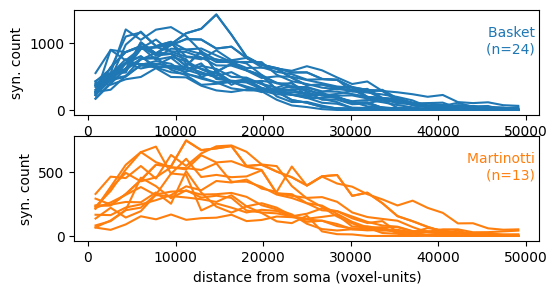

In [6]:
xmax = 100000
xmax = 50000 # zoomed

fig, AX = plt.subplots(2, 1, figsize=(6,3))
for ax, key, color in zip(AX, ['Basket', 'Martinotti'], [plt.cm.tab10(0), plt.cm.tab10(1)]):
    for distances in cells[key]['distances']:
        hist, be = np.histogram(distances, bins=np.linspace(0,xmax,30))
        ax.plot(0.5*(be[1:]+be[:-1]), hist, color=color)
    ax.set_ylabel('syn. count')
    ax.annotate('\n%s \n(n=%i) ' % (key, len(cells[key]['distances'])),
                (1,1), ha='right', va='top', color=color, xycoords='axes fraction')
_ = plt.xlabel('distance from soma (voxel-units)')

### Plot normalized synaptic count as a function of distance to soma

we normalize either by the sum of synapses (density norm) or by the peak count (max. norm)

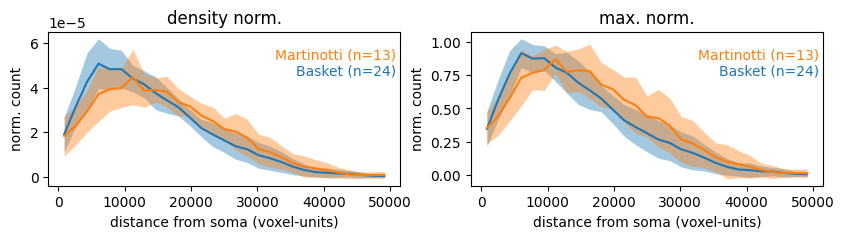

In [7]:
xmax = 100000
xmax = 50000 # zoomed
bins = np.linspace(0,xmax,30)

fig, AX = plt.subplots(1, 2, figsize=(10,2.))
for ax, key, color in zip(AX, ['Basket', 'Martinotti'], [plt.cm.tab10(0), plt.cm.tab10(1)]):
    cells[key]['normD_count'], cells[key]['normM_count'] = [], []
    for distances in cells[key]['distances']:
        # max norm
        hist, be = np.histogram(distances, bins=bins)
        cells[key]['normM_count'].append(hist/hist.max())
        # density norm
        hist, be = np.histogram(distances, bins=bins, density=True)
        cells[key]['normD_count'].append(hist)
        
    mean, sd = np.mean(cells[key]['normD_count'], axis=0), np.std(cells[key]['normD_count'], axis=0)
    AX[0].plot(0.5*(bins[1:]+bins[:-1]), mean, color=color)
    AX[0].fill_between(0.5*(bins[1:]+bins[:-1]), mean-sd, mean+sd, color=color, alpha=0.4, lw=0)
    
        
    mean, sd = np.mean(cells[key]['normM_count'], axis=0), np.std(cells[key]['normM_count'], axis=0)
    AX[1].plot(0.5*(bins[1:]+bins[:-1]), mean, color=color)
    AX[1].fill_between(0.5*(bins[1:]+bins[:-1]), mean-sd, mean+sd, color=color, alpha=0.4, lw=0)
    
    for ax in AX:
        ax.annotate('\n'*(2 if key=='Basket' else 1)+'%s (n=%i) ' % (key, len(cells[key]['distances'])),
                (1,1), ha='right', va='top', color=color, xycoords='axes fraction')
        
_ = AX[0].set_title('density norm.')
_ = AX[1].set_title('max. norm.')
for ax in AX:
    _ = ax.set_xlabel('distance from soma (voxel-units)')
    _ = ax.set_ylabel('norm. count')

In [24]:
def plot_synapses(seg_id, 
                  ax=None, subsampling=10,
                  i=0, j=1, # projection
                  color='k'):
    if ax is None:
        fig, ax = plt.subplots(1)
    
    cell = client.materialize.query_table('nucleus_detection_v0',
                                          filter_equal_dict={'pt_root_id':seg_id})
    
    input_df = client.materialize.synapse_query(post_ids=seg_id)
    
    for n in range(len(input_df))[::subsampling]:
        try:
            ax.scatter([1e-3*(input_df.ctr_pt_position[n][i]-cell.pt_position[0][i])],
                       [1e-3*(input_df.ctr_pt_position[n][j]-cell.pt_position[0][j])], s=1, color=color)
        except BaseException as be:
            pass
        
    ax.set_title('cell: "%i" \nhas n=%i synapses' % (seg_id, len(input_df)), fontsize=6)
    ax.axis('equal')


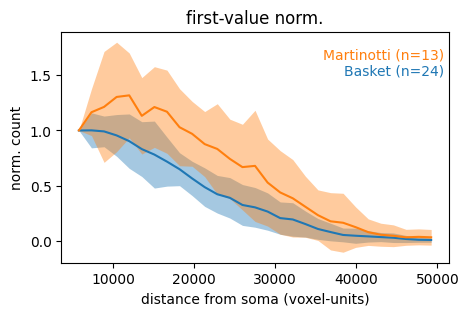

In [31]:
xmax = 100000
xmax = 50000 # zoomed
bins = np.linspace(5000,xmax,30) # starting the count far-enough from the soma

fig, ax = plt.subplots(1, figsize=(5,3.))
for key, color in zip(['Basket', 'Martinotti'], [plt.cm.tab10(0), plt.cm.tab10(1)]):
    cells[key]['norm0_count'] = []
    for distances in cells[key]['distances']:
        # norm
        hist, be = np.histogram(distances, bins=bins)
        cells[key]['norm0_count'].append(hist/hist[0])
        
    mean, sd = np.mean(cells[key]['norm0_count'], axis=0), np.std(cells[key]['norm0_count'], axis=0)
    ax.plot(0.5*(bins[1:]+bins[:-1]), mean, color=color)
    ax.fill_between(0.5*(bins[1:]+bins[:-1]), mean-sd, mean+sd, color=color, alpha=0.4, lw=0)
    
    ax.annotate('\n'*(2 if key=='Basket' else 1)+'%s (n=%i) ' % (key, len(cells[key]['distances'])),
                (1,1), ha='right', va='top', color=color, xycoords='axes fraction')
        
_ = ax.set_title('first-value norm.')
_ = ax.set_xlabel('distance from soma (voxel-units)')
_ = ax.set_ylabel('norm. count')

## Visualizing synapses

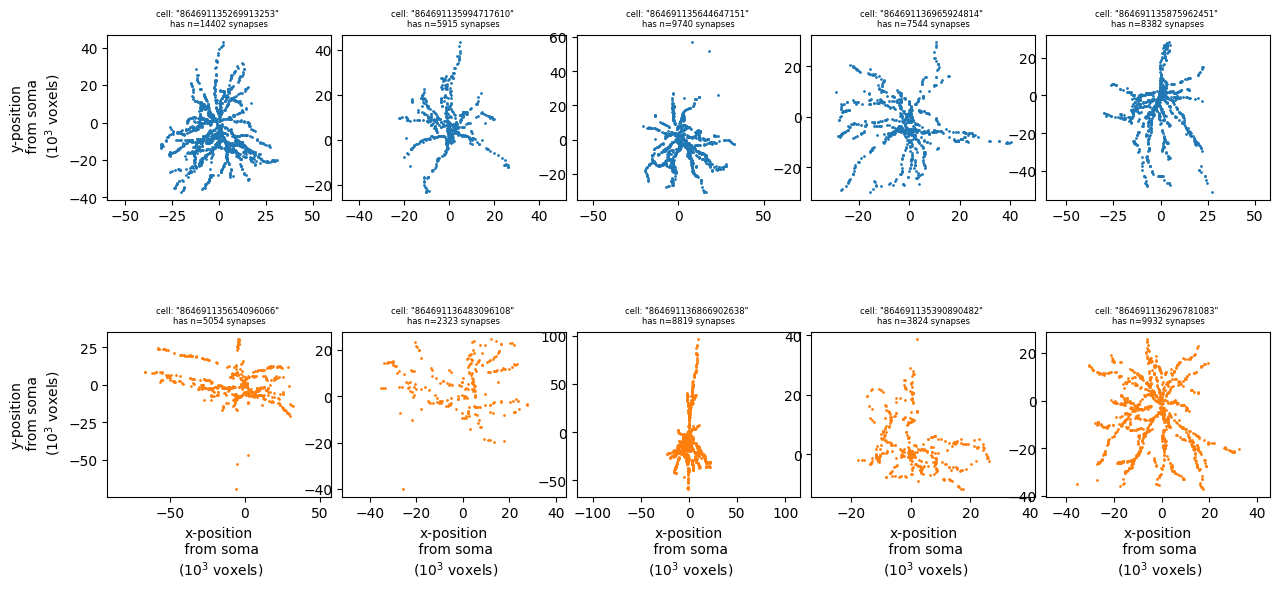

In [32]:
Nplot = 5
fig, AX = plt.subplots(2, Nplot, figsize=(3*Nplot,6))
fig.subplots_adjust(wspace=0.05, hspace=0.8)
for i in range(Nplot):
    plot_synapses(cells['Basket']['segID'][i], ax=AX[0][i], color=plt.cm.tab10(0))
    plot_synapses(cells['Martinotti']['segID'][i], ax=AX[1][i], color=plt.cm.tab10(1))
for ax in [AX[0][0], AX[1][0]]:
    ax.set_ylabel('y-position\n from soma\n (10$^3$ voxels)')
for ax in AX[1]:
    ax.set_xlabel('x-position\n from soma\n (10$^3$ voxels)')

In [6]:
from meshparty import meshwork, trimesh_io
import pcg_skel
import matplotlib.pyplot as plt
import numpy as np
from caveclient import CAVEclient

#datastack_name = 'minnie65_public_v117'
datastack_name = 'minnie65_public_v343' 
client = CAVEclient(datastack_name)
client.materialize.version = 343

mesh_folder = 'meshes'
mm = trimesh_io.MeshMeta(cv_path ="precomputed://gs://iarpa_microns/minnie/minnie65/seg_m343",
                         disk_cache_path=mesh_folder,
                         cache_size=0)

In [7]:
# REDUCED
cells = {
         'Basket':{'segID':[864691135644647151,
                            #
                            864691136965924814,
                            864691135875962451,
                            864691135307240262,
                            864691136601891793,
                            864691135341149893,
                            864691135212725632,
                            864691135939796646,
                            864691135269913253,
                            864691135396580129,
                            864691135771743563,
                            864691135446872916,
                            #
                            864691135403927534,
                            864691135815629903,
                            864691135737012612,
                            864691135873741966,
                            864691135644647151,
                            864691135807467037,
                            864691135528023492,
                            864691135212725632,
                            864691137197014081,
                            864691135307240262]},
    
         'Martinotti':{'segID':[864691135654096066,
                                864691136483096108,
                                864691136866902638,
                                864691135390890482,
                                864691136296781083,
                                864691135697569813,
                                864691135575230238,
                                864691136056318680,
                                864691136296781083,
                                #
                                864691136871043694,
                                864691136436386718,
                                864691135394616306,
                                864691135584090435]}
        }

# debug
#for cType in ['Basket', 'Martinotti']:
#    cells[cType]['segID'] = cells[cType]['segID'][:1]


In [8]:
# check which cells are in the precomputed database
for cType in ['Basket', 'Martinotti']:
    cells[cType]['precomputed_mesh'] = np.zeros(len(cells[cType]['segID']), dtype=bool)
    print('\n    --- %s --- ' % cType)
    for n, neuron_id in enumerate(cells[cType]['segID']):
        try:
            post_mesh = mm.mesh(seg_id = neuron_id, lod=2)
            print('  [ok] --> mesh found for cell:', neuron_id)
            cells[cType]['precomputed_mesh'][n] = True
        except BaseException as be:
            print('  [X] --> NOT found for cell:', neuron_id)


    --- Basket --- 
  [ok] --> mesh found for cell: 864691135644647151
  [X] --> NOT found for cell: 864691136965924814
  [ok] --> mesh found for cell: 864691135875962451
  [X] --> NOT found for cell: 864691135307240262
  [ok] --> mesh found for cell: 864691136601891793
  [ok] --> mesh found for cell: 864691135341149893
  [ok] --> mesh found for cell: 864691135212725632
  [ok] --> mesh found for cell: 864691135939796646
  [X] --> NOT found for cell: 864691135269913253
  [ok] --> mesh found for cell: 864691135396580129
  [ok] --> mesh found for cell: 864691135771743563
  [ok] --> mesh found for cell: 864691135446872916
  [X] --> NOT found for cell: 864691135403927534
  [ok] --> mesh found for cell: 864691135815629903
  [ok] --> mesh found for cell: 864691135737012612
  [X] --> NOT found for cell: 864691135873741966
  [ok] --> mesh found for cell: 864691135644647151
  [X] --> NOT found for cell: 864691135807467037
  [ok] --> mesh found for cell: 864691135528023492
  [ok] --> mesh found 

In [12]:
from caveclient import CAVEclient
import pcg_skel

client = CAVEclient('minnie65_public_v117')

oid = 864691135761488438 # Root id
root_point = [253870, 236989, 20517] # root point in vertex coordinates
sk_l2 = pcg_skel.pcg_skeleton(oid,
                              client=client,
                              refine='all',
                              #root_point=root_point,
                              root_point_resolution=[4,4,40],
                              collapse_soma=True,
                              n_parallel=8)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2344/2344 [00:25<00:00, 93.68it/s]


In [20]:
sk_l2 = pcg_skel.pcg_skeleton(cells['Basket']['segID'][0],
                              client=client,
                              refine='all',
                              #root_point=root_point,
                              root_point_resolution=[4,4,40],
                              collapse_soma=True,
                              n_parallel=8)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12704/12704 [02:25<00:00, 87.12it/s]


In [22]:
bpc_mw_2 = pcg_skel.coord_space_meshwork(
    root_id=cells['Basket']['segID'][0],
    client=client,
    #root_point=bpc_soma_location,
    #root_point_resolution=[4, 4, 40],
    collapse_soma=True,
    synapses="all",
    synapse_table="synapses_pni_2",
)


/home/yann.zerlaut/miniconda3/envs/allen/lib/python3.8/site-packages/caveclient/l2cache.py:78: UserWarning: L2Cache is in an experimental stage
  warnings.warn("L2Cache is in an experimental stage", UserWarning)


HTTPError: 500 Server Error: INTERNAL SERVER ERROR for url: https://minnie.microns-daf.com/l2cache/api/v1/table/minnie65_public_v117/attributes?int64_as_str=False&attribute_names=rep_coord_nm content:b'{\n  "code": 500,\n  "duration": 201.60222053527832,\n  "message": "Dataset minnie65_public_v117 does not have an L2 Cache.",\n  "timestamp": "2022-10-17 10:24:48.628095",\n  "traceback": [\n    "Traceback (most recent call last):\\n",\n    "  File \\"/usr/local/lib/python3.7/site-packages/flask/app.py\\", line 1820, in full_dispatch_request\\n    rv = self.dispatch_request()\\n",\n    "  File \\"/usr/local/lib/python3.7/site-packages/flask/app.py\\", line 1796, in dispatch_request\\n    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)\\n",\n    "  File \\"/usr/local/lib/python3.7/site-packages/middle_auth_client/decorators.py\\", line 265, in decorated_function\\n    return f(*args, **kwargs)\\n",\n    "  File \\"/usr/local/lib/python3.7/site-packages/middle_auth_client/decorators.py\\", line 397, in decorated_function\\n    return f(*args, **kwargs)\\n",\n    "  File \\"./pcgl2cache/app/v1/routes.py\\", line 27, in decorated_function\\n    return f(*args, **kwargs)\\n",\n    "  File \\"./pcgl2cache/app/v1/routes.py\\", line 94, in attributes\\n    common.handle_attributes(table_id), int64_as_str=int64_as_str\\n",\n    "  File \\"./pcgl2cache/app/common.py\\", line 162, in handle_attributes\\n    cache_client = get_l2cache_client(graph_id)\\n",\n    "  File \\"./pcgl2cache/app/utils.py\\", line 47, in get_l2cache_client\\n    assert graph_id in l2cache_config, f\\"Dataset {graph_id} does not have an L2 Cache.\\"\\n",\n    "AssertionError: Dataset minnie65_public_v117 does not have an L2 Cache.\\n"\n  ]\n}\n'

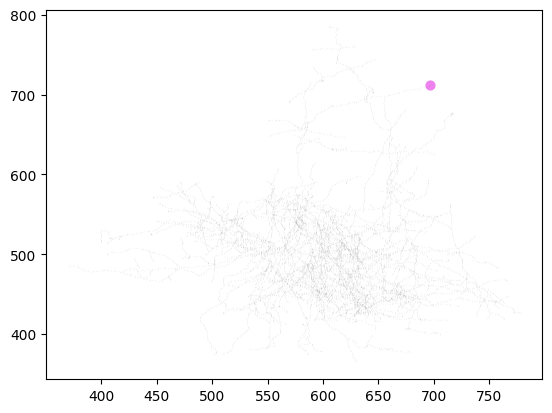

In [21]:
class Nrn:
    def __init__(self, sk):
        self.skeleton = sk
        
nrn = Nrn(sk_l2)
plot_cell(nrn, plt.gca())

In [23]:
from meshparty import skeleton, skeletonize, trimesh_io, meshwork

def compute_skeleton(neuron_id,
                     voxel_resolution = np.array([4,4,40]),
                     soma_radius = 30*1000):

    soma = client.materialize.query_table('nucleus_detection_v0',
                                          filter_equal_dict={'pt_root_id':neuron_id})
    soma_pt= soma.loc[0, 'pt_position']*voxel_resolution
        
    # fetch precomputed mesh
    mesh = mm.mesh(seg_id = neuron_id,
                   lod=2)

    """
    # compute skeleton path
    new_v, new_e, orig_skel_index,\
            new_skel_map = skeletonize.calculate_skeleton_paths_on_mesh(mesh,
                                                                        soma_pt=soma_pt,
                                                                        soma_thresh=soma_radius,
                                                                        return_map=True)
        
    # --------------   find soma and collapse it to single vertex -------------------------- 
    temp_sk = skeletonize.Skeleton(new_v, new_e,
                                       mesh_index=mesh.map_indices_to_unmasked(orig_skel_index),
                                       mesh_to_skel_map = new_skel_map)
    _, close_ind = temp_sk.kdtree.query(soma_pt)
    temp_sk.reroot(close_ind)
        
    soma_verts, soma_r = skeletonize.soma_via_sphere(
                        soma_pt, temp_sk.vertices, temp_sk.edges, soma_radius)
        
    new_v, new_e, soma_skel_map, vert_filter,\
        root_ind = skeletonize.collapse_soma_skeleton(soma_verts,
                                                      soma_pt,
                                                      temp_sk.vertices,
                                                      temp_sk.edges,
                                                      mesh_to_skeleton_map=temp_sk.mesh_to_skel_map,
                                                      collapse_index=None,
                                                      return_filter=True,
                                                      return_soma_ind=True)
        
    # build skeleton
    sk = skeletonize.Skeleton(new_v, new_e,
                              root=root_ind,
                              mesh_index=mesh.map_indices_to_unmasked(orig_skel_index),
                              mesh_to_skel_map=new_skel_map)

    """
    sk = pcg_skel.pcg_skeleton(neuron_id,
                               client=client,
                               refine='all',
                               #root_point=root_point,
                               root_point_resolution=[4,4,40],
                               collapse_soma=True,
                               n_parallel=8)
    
    # build nrn object from mesh and skeleton
    nrn = meshwork.Meshwork(mesh, 
                            seg_id=neuron_id, 
                            skeleton=sk)

        # 
    lvl2_eg = client.chunkedgraph.level2_chunk_graph(neuron_id)
    cv = client.info.segmentation_cloudvolume(progress=False)
    _, l2dict_mesh, _, _ = pcg_skel.build_spatial_graph(lvl2_eg,
                                                        cv)

    # add synapses
    pcg_skel.features.add_synapses(nrn,
                                   "synapses_pni_2",
                                   l2dict_mesh,
                                   client,
                                   root_id=neuron_id,
                                   pre=True,
                                   post=True,
                                   remove_self_synapse=True)
    
    return nrn


In [55]:
for cType in ['Basket', 'Martinotti']:
    
    cells[cType]['nrn'] = []
    
    for n in np.arange(len(cells[cType]['segID']))[cells[cType]['precomputed_mesh']]:
        
        #cells[cType]['nrn'].append(compute_skeleton(cells[cType]['segID'][n]))
        pass

In [ ]:
from meshparty import skeleton, skeletonize, trimesh_io, meshwork

neuron_id = cells['Martinotti']['segID'][1]

nrn = compute_skeleton(neuron_id)

Minishard Indices:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 8537/10332 [02:30<00:21, 84.20it/s]

In [ ]:
plot_cell(cells['Basket']['nrn'][0], plt.gca(), proj_axis2=1) #, with_post=True)

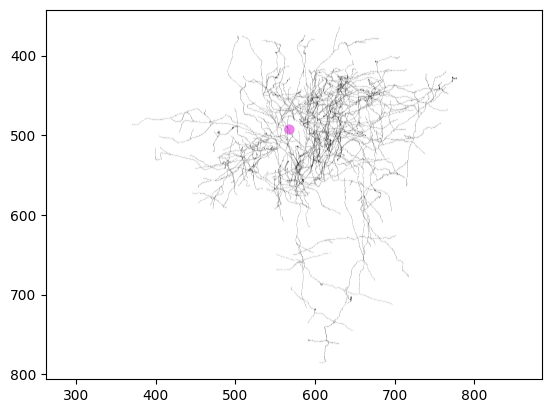

In [14]:
plot_cell(cells['Basket']['nrn'][0], plt.gca(), proj_axis2=1) #, with_post=True)

In [14]:
orig_skel_index.shape

(33582,)

In [13]:

def build_fig(key,
              cmap=plt.cm.magma,
              Ncol = 5):
    
    Nrow = int(len(cells[key]['nrn'])/Ncol+0.99)

    fig, AX = plt.subplots(Nrow, 1, 
                           figsize=(12, 2*Nrow), frameon=False)
    
    fig.subplots_adjust(wspace=0.05, hspace=0.1)
    fig.suptitle(key+ ' cells', fontsize=10)

    for i in range(len(cells[key]['nrn'])):

        plot_cell(cells[key]['nrn'][i], AX[int(i/Ncol)],
                  shift=i*5e2,
                  color=cmap(0.25+i/len(cells[key]['nrn'])/2.))
        
    for ax in AX:
        ax.invert_yaxis()
        ax.axis('equal')
        ax.plot(ax.get_xlim()[0]*np.ones(2), ax.get_ylim()[1]+200*np.arange(2), 'k-', lw=1)
        ax.annotate('200$\mu$m ', (ax.get_xlim()[0], ax.get_ylim()[1]), rotation=90, ha='right', va='top')
        ax.axis('off')
        ax.set_ylabel('depth')
        
    return fig, AX

def plot_cell(nrn, ax, 
              shift=0,
              proj_axis1=0, proj_axis2=1, 
              with_pre = False,
              with_post = False,
              color='k',
              clean=False):

    if with_pre:
        ax.scatter(shift+\
                   nrn.anno.pre_syn.points[:,proj_axis1]/1e3,
                   nrn.anno.pre_syn.points[:,proj_axis2]/1e3,
                   color='tomato', s=8, alpha=.5, label='pre syn.')
    if with_post:
        ax.scatter(shift+\
                   nrn.anno.post_syn.points[:,proj_axis1]/1e3,
                   nrn.anno.post_syn.points[:,proj_axis2]/1e3,
                   color='turquoise', s=8, alpha=.5, label='post syn.')
    
    if clean:
        for cover_path in nrn.skeleton.cover_paths:
            path_verts = nrn.skeleton.vertices[cover_path,:]
            ax.plot(shift+\
                    path_verts[:,proj_axis1]/1e3, 
                    path_verts[:,proj_axis2]/1e3, color=color, lw=0.1)
    else:
        ax.plot(shift+\
                   nrn.skeleton.vertices[:, proj_axis1]/1e3,
                nrn.skeleton.vertices[:, proj_axis2]/1e3, 
                '_', lw=0, ms=0.03, color=color)
    # plot soma
    ax.scatter(shift+\
                   nrn.skeleton.vertices[:, proj_axis1][nrn.skeleton.root]/1e3,
               nrn.skeleton.vertices[:, proj_axis2][nrn.skeleton.root]/1e3,
               s=40,color='violet', label='put. soma')
    


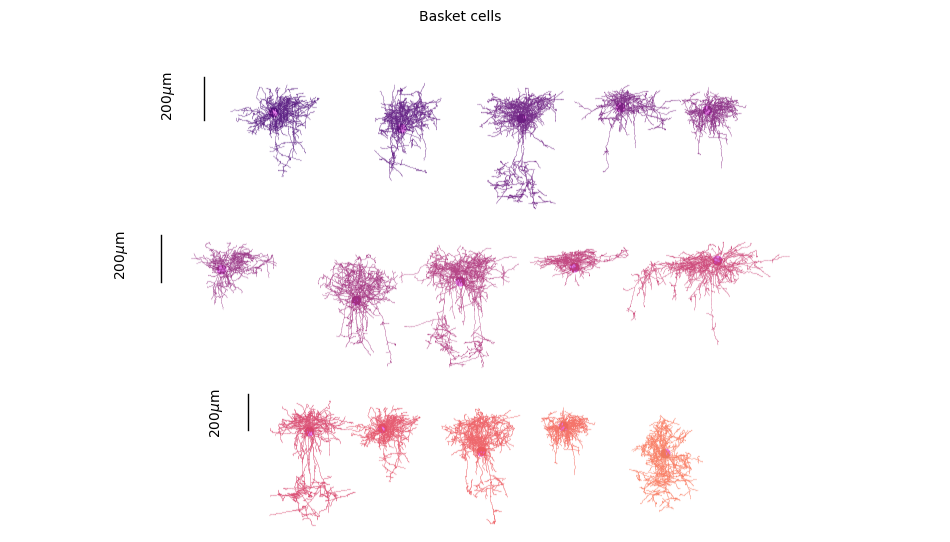

In [32]:
fig, AX = build_fig('Basket')

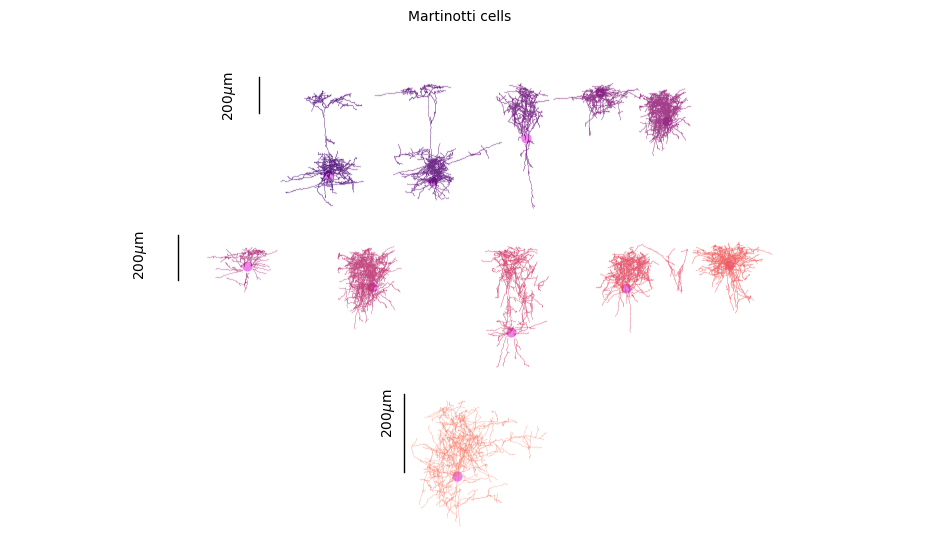

In [33]:
fig, AX = build_fig('Martinotti');

## Synaptic distribution along dendrites

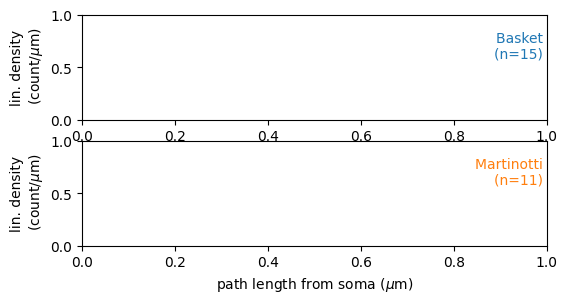

In [42]:
bins = np.linspace(100, 1300, 50) # um

fig, AX = plt.subplots(2, 1, figsize=(6,3))
for ax, key, color in zip(AX, ['Basket', 'Martinotti'], [plt.cm.tab10(0), plt.cm.tab10(1)]):
    for nrn in cells[key]['nrn']:
        try:
            pre_syn_df = nrn.anno.pre_syn.df
            d_syn_path_um = nrn.distance_to_root(pre_syn_df['pre_pt_mesh_ind'] ) / 1_000
            hist, be = np.histogram(d_syn_path_um, bins=bins)
            ax.plot(0.5*(be[1:]+be[:-1]), hist/(bins[1]-bins[0]))#, color=color)
        except BaseException as be:
            pass
    ax.set_ylabel('lin. density\n (count/$\mu$m)')
    ax.annotate('\n%s \n(n=%i) ' % (key, len(cells[key]['nrn'])),
                (1,1), ha='right', va='top', color=color, xycoords='axes fraction')
_ = plt.xlabel('path length from soma ($\mu$m)')

In [58]:
nrn.distance_to_root(nrn.skeleton.root)
#nrn._mesh

IndexError: boolean index did not match indexed array along dimension 0; dimension is 235510 but corresponding boolean dimension is 253677

## Splitting axon and dendrites

In progress [...]

In [ ]:
axon_inds, Q = meshwork.algorithms.split_axon_by_annotation(nrn,
                                                            pre_anno='pre_syn',
                                                            post_anno='post_syn')

In [16]:
for i in range(Nplot):
    plot_synapses(cells['Basket']['segID'][i], ax=AX[0][i], color=plt.cm.tab10(0))
    plot_synapses(cells['Martinotti']['segID'][i], ax=AX[1][i], color=plt.cm.tab10(1))
for ax in [AX[0][0], AX[1][0]]:
    ax.set_ylabel('y-position\n from soma\n (10$^3$ voxels)')
for ax in AX[1]:
    ax.set_xlabel('x-position\n from soma\n (10$^3$ voxels)')

In [18]:
Nmax

15